/Users/fero3l/Development/pyInfinityFlow/test_scripts/mouse_lung_dataset/full_dataset_full_pipeline/outputs/regression_results

In [1]:
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

os.chdir("/Users/fero3l/Development/pyInfinityFlow/test_scripts/"\
    "mouse_lung_dataset/full_dataset_full_pipeline/outputs/regression_results/")

In [2]:
# Read back in the regression results object
adata = sc.read("infinity_flow_object_logicle_redo_umap_and_clustering.h5ad")
adata

AnnData object with n_obs × n_vars = 2630000 × 266
    obs: 'cell_number', 'batch', 'umap-x', 'umap-y', 'leiden'
    var: 'name', 'USE_LOGICLE', 'LOGICLE_T', 'LOGICLE_W', 'LOGICLE_M', 'LOGICLE_A', 'LOGICLE_APPLIED', 'IMPUTED'
    uns: 'cell_assignments', 'groups_to_color', 'leiden', 'markers_df', 'neighbors', 'obs_file_origin', 'pca', 'pca_features', 'silent_var', 'umap'
    obsm: 'X_pca', 'X_umap', 'silent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# NOTE: you may want to silence some features, and not use them for clustering

In [3]:
# Read in previous clustering results
clustering_low_res = pd.read_table("groups.all_cells.txt").set_index("cell")
clustering_high_res = pd.read_table("groups_res_4.all_cells.txt").set_index("UID")

In [21]:
adata.obs['leiden'] = clustering_low_res.loc[adata.obs.index.values, 
    "cluster"].astype(str)

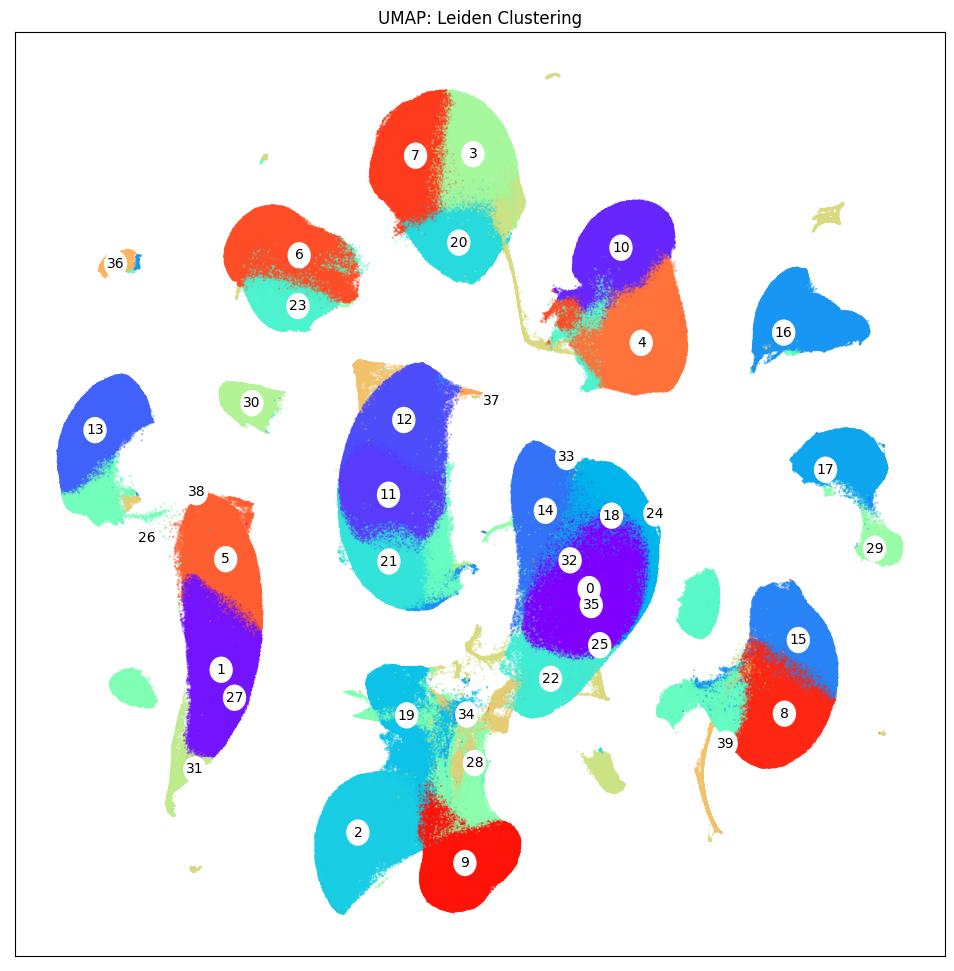

In [22]:
from pyInfinityFlow.Plotting_Utilities import plot_leiden_clusters_over_umap
plot_leiden_clusters_over_umap(adata, verbosity=3)

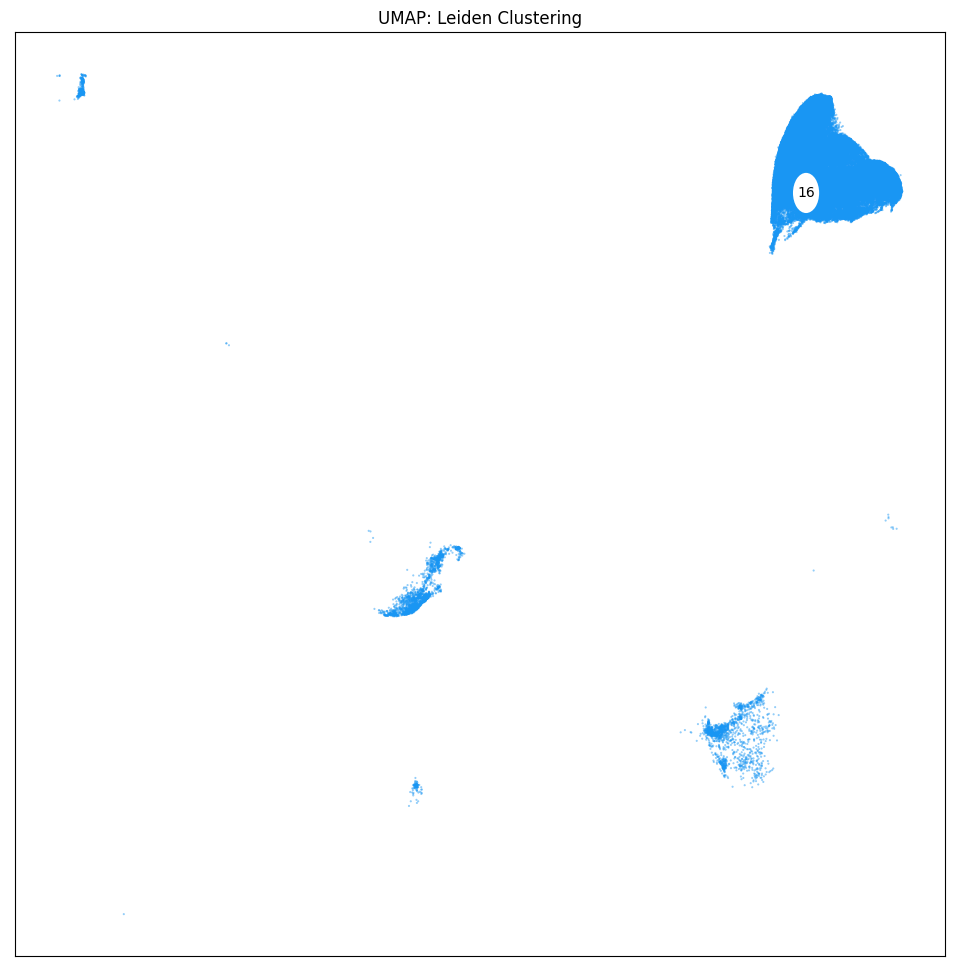

In [25]:
subset_c16 = adata[adata.obs.loc[adata.obs['leiden'] == '16'].index.values,:].copy()
subset_c16.obs['leiden_res_1'] = subset_c16.obs['leiden']
plot_leiden_clusters_over_umap(subset_c16, verbosity=3)

In [34]:
sc.tl.leiden(subset_c16, resolution=0.5)

In [36]:
subset_c16.obs["leiden"].value_counts()

0     11671
1     11219
2     10998
3      8411
4      7604
5      6532
6      6513
7      5919
8      1786
9      1132
10      240
Name: leiden, dtype: int64

In [39]:
from pyInfinityFlow.Plotting_Utilities import assign_rainbow_colors_to_groups

subset_c16.uns['groups_to_color'] = assign_rainbow_colors_to_groups(subset_c16.obs["leiden"])

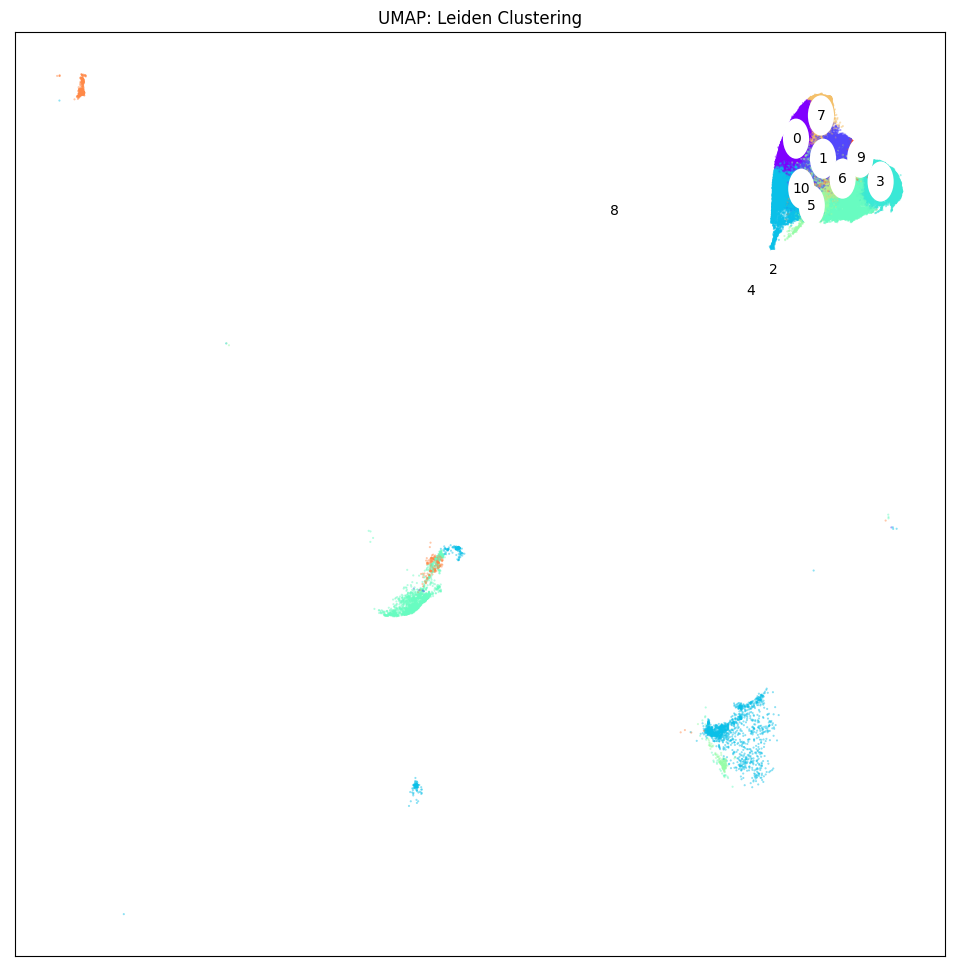

In [40]:
plot_leiden_clusters_over_umap(subset_c16, verbosity=3)

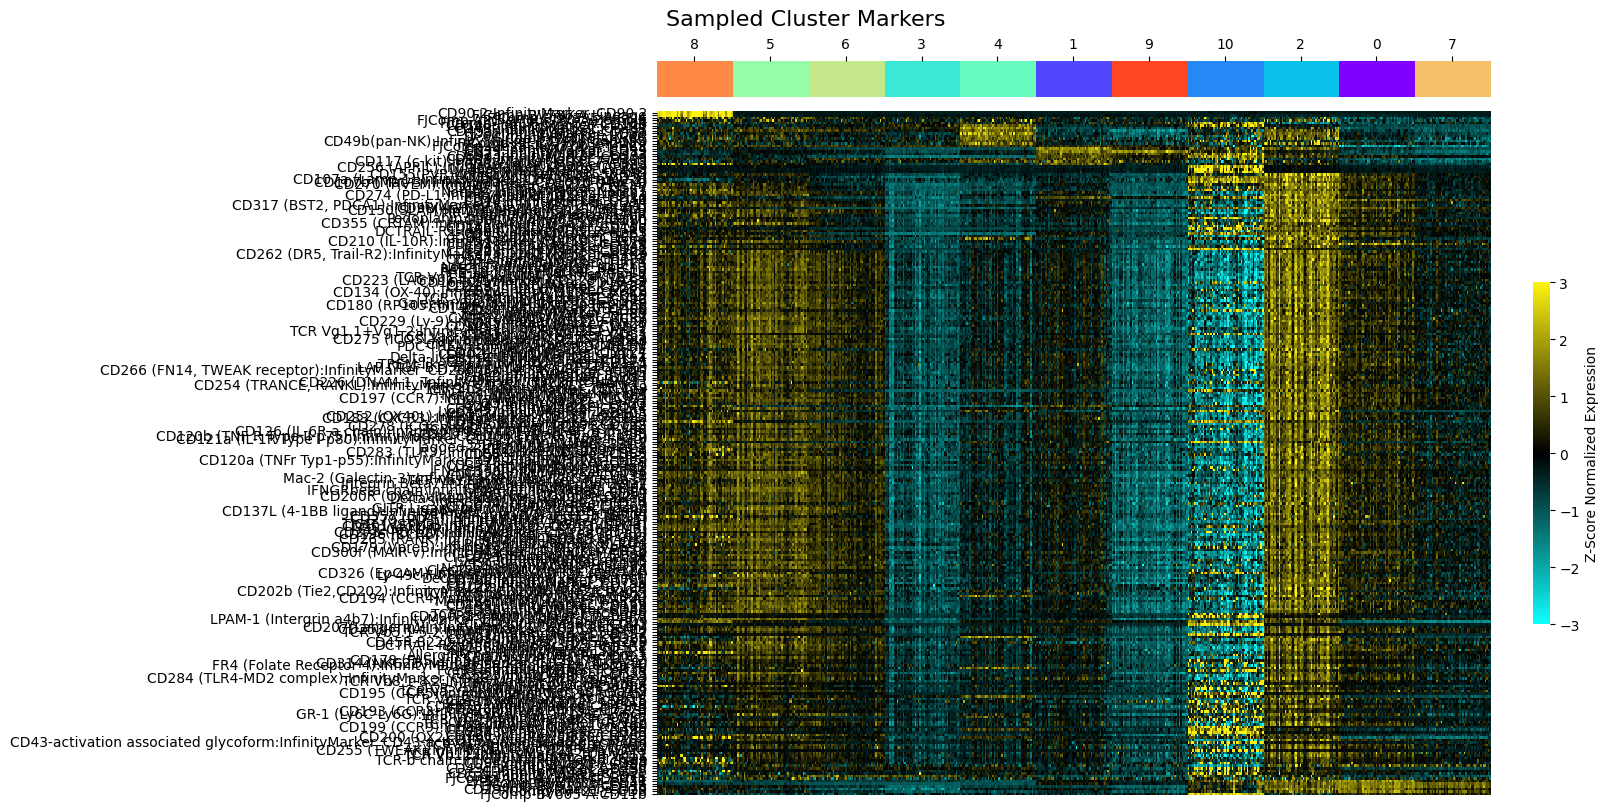

In [62]:
# Find markers
from pyInfinityFlow.InfinityFlow_Utilities import find_markers_from_anndata
markers_df, cell_assignments = find_markers_from_anndata(subset_c16, 
    output_dir="cluster_16_subclustering", 
    groups_to_colors=subset_c16.uns['groups_to_color'])

In [42]:
adata_out = adata.copy()

In [45]:
adata_out.obsm['silent'].columns.values

array(['FJComp-PE(yg)-A', 'FSC-A', 'FSC-H', 'FSC-W', 'Isotype_AHIgG',
       'Isotype_SHIgG', 'Isotype_mIgG1', 'Isotype_mIgG2a',
       'Isotype_mIgG2b', 'Isotype_mIgM', 'Isotype_rIgG1',
       'Isotype_rIgG2a', 'Isotype_rIgG2b', 'Isotype_rIgG2c',
       'Isotype_rIgM', 'SSC-A', 'SSC-H', 'SSC-W', 'Time'], dtype=object)

In [46]:
from pyInfinityFlow.InfinityFlow_Utilities import move_features_out_of_silent

# Add back the scatter channels
scatter_channels = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
adata_out = move_features_out_of_silent(adata_out, scatter_channels)
adata_out.var.head()


,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
33D1,InfinityMarker_33D1,True,3000000.0,0.0,3.0,1.0,True,True
Allergin-1,InfinityMarker_Allergin-1,True,3000000.0,0.0,3.0,1.0,True,True
B7-H4,InfinityMarker_B7-H4,True,3000000.0,0.0,3.0,1.0,True,True
CD103,InfinityMarker_CD103,True,3000000.0,0.0,3.0,1.0,True,True
CD105,InfinityMarker_CD105,True,3000000.0,0.0,3.0,1.0,True,True


In [51]:
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

r_df, p_df = marker_finder(anndata_to_df(adata, 
    use_raw_feature_names=False), adata.obs['leiden'])

In [54]:
r_df['16'].sort_values()

FJComp-GFP-A:CD45a488                          -0.299421
H-2:InfinityMarker_H-2                         -0.289884
CD48:InfinityMarker_CD48                       -0.256619
CD11a:InfinityMarker_CD11a                     -0.238364
CD43:InfinityMarker_CD43                       -0.190271
                                                  ...   
CD107b (Mac-3):InfinityMarker_CD107b (Mac-3)    0.133575
CD51:InfinityMarker_CD51                        0.148984
Ly-51:InfinityMarker_Ly-51                      0.176982
CD63:InfinityMarker_CD63                        0.253712
CD59a:InfinityMarker_CD59a                      0.312083
Name: 16, Length: 266, dtype: float64

In [48]:
from pyInfinityFlow.InfinityFlow_Utilities import apply_inverse_logicle_to_anndata
apply_inverse_logicle_to_anndata(adata_out)

()

In [49]:
from pyInfinityFlow.InfinityFlow_Utilities import write_anndata_to_fcs
write_anndata_to_fcs(adata_out, 
    fcs_file_path="mouse_lung_infinityflow_dataset.fcs", 
    add_umap=True, 
    verbosity=3)

Omitting spillover matrix...
WARNING! TEXT segment value for key $P267S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P268S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P269S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P270S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P271S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P272S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P273S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P274S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P267S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P268S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P269S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P270S is empty. Excluding from w

In [56]:
### Filter to the markers of predominant clusters
markers_df = pd.read_csv("cluster_16_subclustering/cluster_markers.csv")
markers_df.head()

,UID,marker,top_cluster,pearson_r,p_value
0,158,CD90.2:InfinityMarker_CD90.2,8,0.836284,0.000000e+00
1,185,FJComp-BV786-A:Lineage,8,0.812255,0.000000e+00
2,178,FJComp-BUV395-A:CD4,5,0.265156,0.000000e+00
3,176,FJComp-APC-eFlour780-A:Zombie,5,0.150321,0.000000e+00
4,188,FJComp-PerCP-Cy5-5-A:CD103,3,0.127542,7.348274e-259


In [57]:
markers_df["top_cluster"].value_counts()

2     236
4       9
1       7
0       6
10      3
8       2
5       2
3       1
Name: top_cluster, dtype: int64

In [59]:
markers_df["top_cluster"] = markers_df["top_cluster"].astype(str)

In [60]:
filtered_markers = markers_df.loc[markers_df["top_cluster"].isin([\
    '4', '1', '0', '7'])]

In [77]:
import numpy as np
import seaborn as sns
from pyInfinityFlow.Plotting_Utilities import blue_black_yellow_cmap
import traceback
from scipy.stats import zscore

def plot_markers_df(input_df, ordered_markers_df, ordered_cells_df, 
        groups_to_colors, path_to_save_figure):
    """ Plots a heatmap of the MarkerFinder results

    This function takes a pandas.DataFrame of values, a markers_df and 
    cell_assignments from pyInfinityFlow.InfinityFlow_Utilities.
    find_markers_from_anndata to plot a heatmap of the markers.

    Note
    ----
    This function expects pyInfinityFlow.InfinityFlow_Utilities.
    find_markers_from_anndata to have already been run.
        
    Arguments
    ---------
    input_df : pandas.DataFrame
        Data to plot. The columns must intersect with features in the \
        ordered_markers_df and the rows must intersect with the cells in \
        (Required)
    ordered_markers_df : pandas.DataFrame
        The markers_df output from pyInfinityFlow.InfinityFlow_Utilities.\
        find_markers_from_anndata (Required)
    ordered_cells_df : pandas.DataFrame
        The cell_assignments output from pyInfinityFlow.InfinityFlow_Utilities.\
        find_markers_from_anndata (Required)
    groups_to_colors : dict {str:str}
        Dictionary of cluster-names to assigned colors (hexadecimal value) \
        The pyInfinityFlow.Plotting_Utilities.assign_rainbow_colors_to_groups \
        can be used to generate this dictionary from a list of clusters. \
        (Required)
    path_to_save_figure : str
        The path to save the figure. (Required)
    
    Returns
    -------
    None
        Saves the heatmap to the file specified by path_to_save_figure

    """
    try:
        groups_to_colors = pd.Series(groups_to_colors)
        # Filter the input data matrix to the markers and cells of interest
        input_df = input_df.loc[ordered_cells_df["cell"].values, 
            ordered_markers_df["marker"].values].T
        # Map the order of the groups_to_colors to make a cmap
        groups_to_order = pd.Series(list(range(len(groups_to_colors))),
            index=groups_to_colors.index.values)
        # Build top heatmap to label clusters
        cell_labels_df = pd.DataFrame({"cluster": [groups_to_order[item] for \
                item in ordered_cells_df["top_cluster"].values]}, 
            index=ordered_cells_df["cell"].values).T
        # Build df to add cluster label ticks
        label_to_position = pd.pivot_table(pd.DataFrame({\
                "cluster": ordered_cells_df["top_cluster"].values,
                "position": list(range(ordered_cells_df.shape[0]))}), 
            index="cluster", 
            values="position", 
            aggfunc=np.mean)["position"].sort_values()
        # Z-score normalize the expression matrix
        z_df = input_df.apply(lambda x: pd.Series(zscore(x.values), 
            index=x.index.values), axis=1)
        # Build the heatmap
        plt.close("all")
        fig = plt.figure(constrained_layout=True, figsize=(16,8))
        ax = fig.add_gridspec(20, 1)
        ax1 = fig.add_subplot(ax[:1, 0])
        ax2 = fig.add_subplot(ax[1:, 0])
        heat1 = sns.heatmap(cell_labels_df,
            yticklabels=False,
            xticklabels=False,
            cmap=sns.color_palette(groups_to_colors.values),
            cbar=False,
            ax=ax1)
        ax1.set_xticks(label_to_position.values)
        ax1.set_xticklabels(label_to_position.index.values)
        ax1.xaxis.tick_top()
        heat2 = sns.heatmap(z_df, 
            vmin=-3, 
            vmax=3, 
            cmap=blue_black_yellow_cmap,
            xticklabels=False,
            yticklabels=True,
            cbar=True,
            cbar_kws={"shrink": 0.5},
            ax=ax2)
        ax2.collections[0].colorbar.set_label("Z-Score Normalized Expression")
        fig.suptitle('Sampled Cluster Markers', fontsize=16)
        plt.savefig(path_to_save_figure)
    except Exception as e:
        print(traceback.format_exc())
        print("Warning! Failed to run plot_markers_df. See above Exception.")

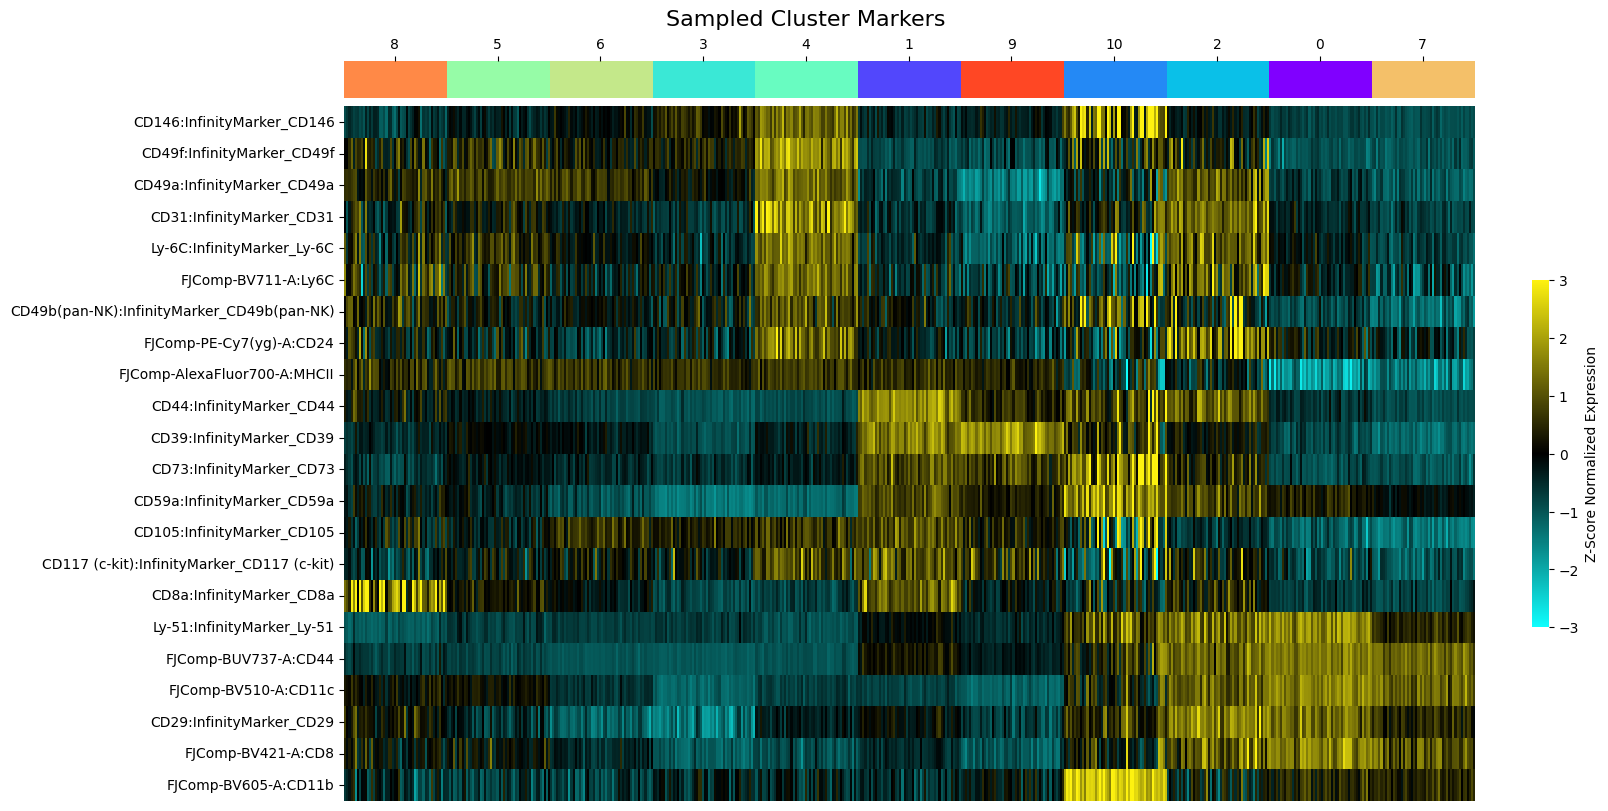

In [78]:
plot_markers_df(\
        input_df=anndata_to_df(subset_c16, use_raw_feature_names=False), 
        ordered_markers_df=filtered_markers, 
        ordered_cells_df=cell_assignments, 
        groups_to_colors=subset_c16.uns['groups_to_color'], 
        path_to_save_figure="cluster_16_subclustering/filtered_markers_cluster_16_subclustering.pdf")